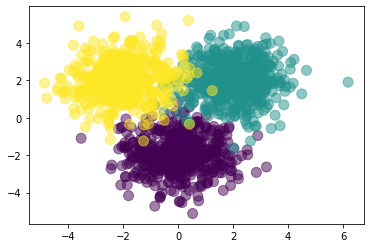

In [0]:
import numpy as np
import matplotlib.pyplot as plt

#generate random data
n = 500

X1 = np.random.randn(n, 2) + np.array([0, -2])
X2 = np.random.randn(n, 2) + np.array([2, 2])
X3 = np.random.randn(n, 2) + np.array([-2, 2])
X = np.vstack([X1, X2, X3])

Y = np.array([0]*n + [1]*n + [2]*n)

plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, alpha=0.5)
plt.show()

T = np.zeros((len(Y), 3))
for i in range(len(Y)):
  T[i, Y[i]] = 1

In [0]:
def sigmoid(X):
  return 1/(1 + np.exp(-X))

def softmax(y):
  ye = np.exp(y)
  ys = np.sum(ye, axis=1, keepdims=True)
  return ye/ys

def feedforward(X, W1, b1, W2, b2):
  Z = sigmoid(X.dot(W1) + b1)
  Y = softmax(Z.dot(W2) + b2)

  return Y, Z

def cost(T, output):
  return -np.sum(T * np.log(output + 1e-8))

def der_w2(Z, T, Y):
  return Z.T.dot(Y-T)

def der_b2(T, Y):
  return (Y-T).sum(axis=0)

def der_w1(X, Z, T, Y, W):
  return X.T.dot((Y-T).dot(W2.T)*Z*(1-Z))

def der_b1(T, Y, W2, Z):
  return ((Y-T).dot(W2.T)*Z*(1-Z)).sum(axis=0)

def predict(p_y):
    return np.argmax(p_y, axis=1)

def error_rate(p_y, t):
    prediction = predict(p_y)
    return np.mean(predict(p_y) != predict(t))

In [0]:
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

X, T = shuffle(X, T)
X_train, X_test, Y_train, Y_test = train_test_split(X, T, test_size=0.2)

N, D = X_train.shape
M = 2
K = 3

# Constant LR
W1 = np.random.randn(D, M) / np.sqrt(D)
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)
LL = []
lr = 0.001
reg = 0.01

t0 = datetime.now()
for epoch in range(100):
  output, hidden = feedforward(X_train, W1, b1, W2, b2)

  #gradient descent!
  W2 -= lr *(der_w2(hidden, Y_train, output) + reg*W2)
  b2 -= lr *(der_b2(Y_train, output) + reg*b2)
  W1 -= lr *(der_w1(X_train, hidden, Y_train, output, W2) + reg*W1)
  b1 -= lr *(der_b1(Y_train, output, W2, hidden) + reg*b1)

  output_test, _ = feedforward(X_test, W1, b1, W2, b2)
  ll = cost(output_test, Y_test)
  LL.append(ll)

output, _ = feedforward(X_test, W1, b1, W2, b2)
print("Final error rate:", error_rate(output, Y_test))
print("Elapsed time for constant LR:", datetime.now() - t0)

Final error rate: 0.02666666666666667
Elapsed time for constant LR: 0:00:00.043354


In [0]:
# RMSProp
W1 = np.random.randn(D, M) / np.sqrt(D)
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)
LL_rms = []
lr = 0.1
reg = 0.01
decay = 0.999
eps = 1e-10
cache_W2, cache_b2, cache_W1, cache_b1 = 1, 1, 1, 1

t0 = datetime.now()
for epoch in range(100):
  output, hidden = feedforward(X_train, W1, b1, W2, b2)

  #gradients
  gW2 = der_w2(hidden, Y_train, output) + reg*W2
  gb2 = der_b2(Y_train, output) + reg*b2
  gW1 = der_w1(X_train, hidden, Y_train, output, W2) + reg*W1
  gb1 = der_b1(Y_train, output, W2, hidden) + reg*b1

  #cache update
  cache_W2 = decay*cache_W2 + (1-decay)*gW2**2
  cache_b2 = decay*cache_b2 + (1-decay)*gb2**2
  cache_W1 = decay*cache_W1 + (1-decay)*gW1**2
  cache_b1 = decay*cache_b1 + (1-decay)*gb1**2

  #final updates
  W2 -= lr * gW2/(np.sqrt(cache_W2) + eps)
  W1 -= lr * gW1/(np.sqrt(cache_W1) + eps)
  b2 -= lr * gb2/(np.sqrt(cache_b2) + eps)
  b1 -= lr * gb1/(np.sqrt(cache_b1) + eps)

  output_test, _ = feedforward(X_test, W1, b1, W2, b2)
  ll = cost(output_test, Y_test)
  LL_rms.append(ll)

output, _ = feedforward(X_test, W1, b1, W2, b2)
print("Final error rate:", error_rate(output, Y_test))
print("Elapsed time for RMSProp:", datetime.now() - t0)

Final error rate: 0.04
Elapsed time for RMSProp: 0:00:00.046644


In [0]:
# Adam
W1 = np.random.randn(D, M) / np.sqrt(D)
b1 = np.zeros(M)
W2 = np.random.randn(M, K) / np.sqrt(M)
b2 = np.zeros(K)
LL_adam = []
lr = 0.1
reg = 0.01
eps = 1e-8
mW2, mb2, mW1, mb1 = 0, 0, 0, 0
vW2, vb2, vW1, vb1 = 0, 0, 0, 0
beta1, beta2 = 0.99, 0.99
t = 1

t0 = datetime.now()
for epoch in range(100):
  output, hidden = feedforward(X_train, W1, b1, W2, b2)

  #gradients
  gW2 = der_w2(hidden, Y_train, output) + reg*W2
  gb2 = der_b2(Y_train, output) + reg*b2
  gW1 = der_w1(X_train, hidden, Y_train, output, W2) + reg*W1
  gb1 = der_b1(Y_train, output, W2, hidden) + reg*b1

  #mean
  mW2 = beta1*mW2 + (1-beta1)*gW2
  mb2 = beta1*mb2 + (1-beta1)*gb2
  mW1 = beta1*mW1 + (1-beta1)*gW1
  mb1 = beta1*mb1 + (1-beta1)*gb1

  #variance
  vW2 = beta2*vW2 + (1-beta2)*gW2**2
  vb2 = beta2*vb2 + (1-beta2)*gb2**2
  vW1 = beta2*vW1 + (1-beta2)*gW1**2
  vb1 = beta2*vb1 + (1-beta2)*gb1**2

  #mean correction
  denom = 1 - beta1**t
  mW2_hat = mW2/denom
  mb2_hat = mb2/denom
  mW1_hat = mW1/denom
  mb1_hat = mb1/denom

  #variance correction
  denom = 1 - beta2**t
  vW2_hat = vW2/denom
  vb2_hat = vb2/denom
  vW1_hat = vW1/denom
  vb1_hat = vb1/denom

  #final updates
  W2 -= lr * mW2/np.sqrt(vW2_hat + eps)
  W1 -= lr * mW1/np.sqrt(vW1_hat + eps)
  b2 -= lr * mb2/np.sqrt(vb2_hat + eps)
  b1 -= lr * mb1/np.sqrt(vb1_hat + eps)

  t += 1

  output_test, _ = feedforward(X_test, W1, b1, W2, b2)
  ll = cost(output_test, Y_test)
  LL_adam.append(ll)

output, _ = feedforward(X_test, W1, b1, W2, b2)
print("Final error rate:", error_rate(output, Y_test))
print("Elapsed time for Adam:", datetime.now() - t0)

Final error rate: 0.04
Elapsed time for Adam: 0:00:00.052921


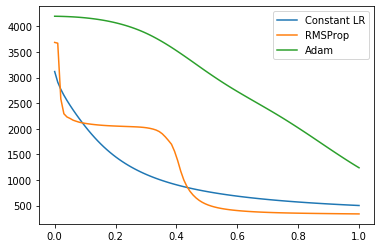

In [0]:
x1 = np.linspace(0, 1, len(LL))
plt.plot(x1, LL, label="Constant LR")
x2 = np.linspace(0, 1, len(LL_rms))
plt.plot(x2, LL_rms, label="RMSProp")
x2 = np.linspace(0, 1, len(LL_adam))
plt.plot(x2, LL_adam, label="Adam")
plt.legend()
plt.show()